In [1]:
https://www.kaggle.com/datasets/howisusmanali/mobile-prices-2023
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from feature_engine.encoding import RareLabelEncoder
from catboost import CatBoostRegressor, Pool
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
rare_encoder=RareLabelEncoder(tol=0.005, n_categories=1, max_n_categories=50)
label_encoder=LabelEncoder()

In [3]:
df = pd.read_csv('D:\PyCharmProject\MobilePrices\mobile_prices_2023.csv')

In [4]:
df.head()

,Phone Name,Rating ?/5,Number of Ratings,RAM,ROM/Storage,Back/Rare Camera,Front Camera,Battery,Processor,Price in INR,Date of Scraping
0,"POCO C50 (Royal Blue, 32 GB)",4.2,"33,561",2 GB RAM,32 GB ROM,8MP Dual Camera,5MP Front Camera,5000 mAh,"Mediatek Helio A22 Processor, Upto 2.0 GHz Pro...","₹5,649",2023-06-17
1,"POCO M4 5G (Cool Blue, 64 GB)",4.2,"77,128",4 GB RAM,64 GB ROM,50MP + 2MP,8MP Front Camera,5000 mAh,Mediatek Dimensity 700 Processor,"₹11,999",2023-06-17
2,"POCO C51 (Royal Blue, 64 GB)",4.3,"15,175",4 GB RAM,64 GB ROM,8MP Dual Rear Camera,5MP Front Camera,5000 mAh,Helio G36 Processor,"₹6,999",2023-06-17
3,"POCO C55 (Cool Blue, 64 GB)",4.2,"22,621",4 GB RAM,64 GB ROM,50MP Dual Rear Camera,5MP Front Camera,5000 mAh,Mediatek Helio G85 Processor,"₹7,749",2023-06-17
4,"POCO C51 (Power Black, 64 GB)",4.3,"15,175",4 GB RAM,64 GB ROM,8MP Dual Rear Camera,5MP Front Camera,5000 mAh,Helio G36 Processor,"₹6,999",2023-06-17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Phone Name         1836 non-null   object 
 1   Rating ?/5         1836 non-null   float64
 2   Number of Ratings  1836 non-null   object 
 3   RAM                1836 non-null   object 
 4   ROM/Storage        1662 non-null   object 
 5   Back/Rare Camera   1827 non-null   object 
 6   Front Camera       1435 non-null   object 
 7   Battery            1826 non-null   object 
 8   Processor          1781 non-null   object 
 9   Price in INR       1836 non-null   object 
 10  Date of Scraping   1836 non-null   object 
dtypes: float64(1), object(10)
memory usage: 157.9+ KB


In [5]:
df.isna().sum()

Phone Name             0
Rating ?/5             0
Number of Ratings      0
RAM                    0
ROM/Storage          174
Back/Rare Camera       9
Front Camera         401
Battery               10
Processor             55
Price in INR           0
Date of Scraping       0
dtype: int64

In [6]:
#check duplicates and delete
df.duplicated().sum()

69

In [7]:
df = df.drop_duplicates().reset_index()

In [8]:
#Group unique companies
df['Brand'] = df['Phone Name'].str.split(" ").str[0]
df['Brand'].unique()

array(['POCO', 'realme', 'Realme', 'APPLE', 'Apple', 'SAMSUNG', 'OPPO',
       'Google', 'vivo', 'Nothing', 'REDMI', 'Redmi', 'Mi', 'Xiaomi',
       '10A', '�9A', 'Nokia', 'MOTOROLA', 'A10E', 'Motorola', 'a', 'Moto',
       'OnePlus', 'Huawei', 'Nexus', 'Alcatel', 'Lenovo', 'Infinix'],
      dtype=object)

In [9]:
df['Brand'] = df['Brand'].str.replace('realme','Realme')
df['Brand'] = df['Brand'].str.replace('APPLE','Apple')
df['Brand'] = df['Brand'].str.replace('REDMI','Redmi')
df['Brand'] = df['Brand'].str.replace('Xiaomi','Xiaomi')
df['Brand'] = df['Brand'].str.replace('Motorola','MOTOROLA')
df['Brand'] = df['Brand'].str.replace('Moto','MOTOROLA')

In [10]:
df['Brand'].unique()

array(['POCO', 'Realme', 'Apple', 'SAMSUNG', 'OPPO', 'Google', 'vivo',
       'Nothing', 'Redmi', 'Mi', 'Xiaomi', '10A', '�9A', 'Nokia',
       'MOTOROLA', 'A10E', 'a', 'OnePlus', 'Huawei', 'Nexus', 'Alcatel',
       'Lenovo', 'Infinix'], dtype=object)

In [11]:
df['Brand'] = df['Brand'].str.replace('10A','Redmi')
df['Brand'] = df['Brand'].str.replace('�9A','Redmi')
df['Brand'] = df['Brand'].str.replace('A10E','SAMSUNG')
df['Brand'] = df['Brand'].str.replace(r'\ba\b','SAMSUNG')

The default value of regex will change from True to False in a future version.


In [12]:
df['Brand'].unique()

array(['POCO', 'Realme', 'Apple', 'SAMSUNG', 'OPPO', 'Google', 'vivo',
       'Nothing', 'Redmi', 'Mi', 'Xiaomi', 'Nokia', 'MOTOROLA', 'OnePlus',
       'Huawei', 'Nexus', 'Alcatel', 'Lenovo', 'Infinix'], dtype=object)

In [13]:
df1=df.copy()

In [14]:
#check for any other currency symbols
df1['CurrencyCheck'] = df['Price in INR'].str[0]
df1['CurrencyCheck'].unique()

array(['₹'], dtype=object)

In [15]:
df1=df1.drop(columns=['CurrencyCheck'])

In [16]:
#take out currency symbol and commas
def convertPrice(x):
    x=x.replace('₹','')
    x=x.replace(',','')
    return int(x)

In [17]:
df1['Price in INR']=df1['Price in INR'].apply(convertPrice)

In [18]:
df1['ROM/Storage'].str.contains('RAM').any()

False

In [19]:
df1['RAM'].str.contains('ROM').any()

True

In [20]:
#move RAM entries with 'ROM' to ROM column
def fixStorage(x):
    if "ROM" in x['RAM']:
        x['ROM/Storage'] = x['RAM']
        x['RAM'] = None
    return x

In [21]:
df1=df1.apply(fixStorage, axis=1)

In [22]:
df1['RAM'].str.contains('ROM').any()

False

In [23]:
df1['ROM/Storage'].str.contains('RAM').any()

False

In [24]:
#check and replace null values
df1.isna().sum()

index                  0
Phone Name             0
Rating ?/5             0
Number of Ratings      0
RAM                  161
ROM/Storage           12
Back/Rare Camera       8
Front Camera         381
Battery                9
Processor             49
Price in INR           0
Date of Scraping       0
Brand                  0
dtype: int64

In [25]:
#Replace entries in processor with non-legitimate values
keywords = ['warranty', 'months','year','month','years']
def fixProcessor(x):    
    if any(word in x.lower() for word in keywords):
        return 'None'
    else:
        return x

In [26]:
df1['Processor']=df1['Processor'].fillna('None')
df1['Processor']=df1['Processor'].apply(fixProcessor)

In [27]:
for col in ['RAM','ROM/Storage','Front Camera','Battery','Back/Rare Camera']:
    df1[col]=df1[col].fillna('None')

In [28]:
df1.isna().sum()

index                0
Phone Name           0
Rating ?/5           0
Number of Ratings    0
RAM                  0
ROM/Storage          0
Back/Rare Camera     0
Front Camera         0
Battery              0
Processor            0
Price in INR         0
Date of Scraping     0
Brand                0
dtype: int64

In [29]:
#Drop unnecessary columns
for col in ['Phone Name','Number of Ratings','Date of Scraping','index']:
    df1=df1.drop(col, axis=1)

In [30]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1767 entries, 0 to 1766
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rating ?/5        1767 non-null   float64
 1   RAM               1767 non-null   object 
 2   ROM/Storage       1767 non-null   object 
 3   Back/Rare Camera  1767 non-null   object 
 4   Front Camera      1767 non-null   object 
 5   Battery           1767 non-null   object 
 6   Processor         1767 non-null   object 
 7   Price in INR      1767 non-null   int64  
 8   Brand             1767 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 124.4+ KB


In [31]:
#EDA dataframe
dfeda=df1.copy()

In [32]:
dfeda.head()

,Rating ?/5,RAM,ROM/Storage,Back/Rare Camera,Front Camera,Battery,Processor,Price in INR,Brand
0,4.2,2 GB RAM,32 GB ROM,8MP Dual Camera,5MP Front Camera,5000 mAh,"Mediatek Helio A22 Processor, Upto 2.0 GHz Pro...",5649,POCO
1,4.2,4 GB RAM,64 GB ROM,50MP + 2MP,8MP Front Camera,5000 mAh,Mediatek Dimensity 700 Processor,11999,POCO
2,4.3,4 GB RAM,64 GB ROM,8MP Dual Rear Camera,5MP Front Camera,5000 mAh,Helio G36 Processor,6999,POCO
3,4.2,4 GB RAM,64 GB ROM,50MP Dual Rear Camera,5MP Front Camera,5000 mAh,Mediatek Helio G85 Processor,7749,POCO
4,4.3,4 GB RAM,64 GB ROM,8MP Dual Rear Camera,5MP Front Camera,5000 mAh,Helio G36 Processor,6999,POCO


In [34]:
#check company spread in the data
total_price_company=dfeda.groupby(by='Brand')['Price in INR'].sum()
num_company=dfeda['Brand'].value_counts().sort_values()

<Axes: title={'center': 'Number of Phones per Company'}, xlabel='Company', ylabel='Number of Phones'>

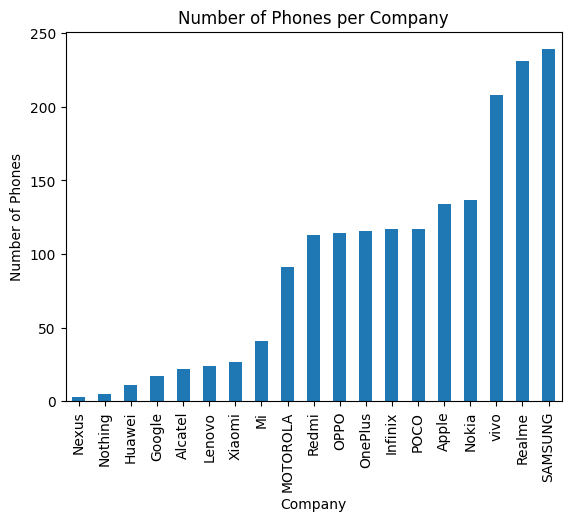

In [35]:
num_company.plot(kind="bar", xlabel="Company", ylabel="Number of Phones", title="Number of Phones per Company")

In [36]:
avg_price_company=(total_price_company.div(num_company)).sort_values()

<Axes: title={'center': 'Average Price of Phone per Company'}, xlabel='Company', ylabel='Price in INR'>

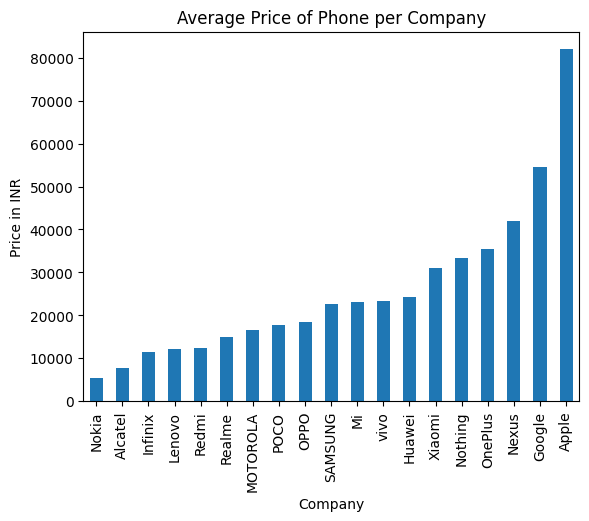

In [37]:
avg_price_company.plot(kind="bar", xlabel="Company", ylabel="Price in INR", title="Average Price of Phone per Company")

In [38]:
#function to check price in relation to other features
def price_relation(df,col,ascending=True):
    df_none=df.loc[df[col]!='None']
    df_price_sum=df_none.groupby(by=col)['Price in INR'].sum().sort_values()
    col_types=df_none[col].value_counts()
    price_relation=(df_price_sum.div(col_types)).sort_values(ascending=ascending)
    return price_relation

In [39]:
avg_price_camera_front=price_relation(dfeda,'Front Camera')

<Axes: title={'center': 'Avg Price Front Camera '}, xlabel='Price in INR', ylabel='Camera type'>

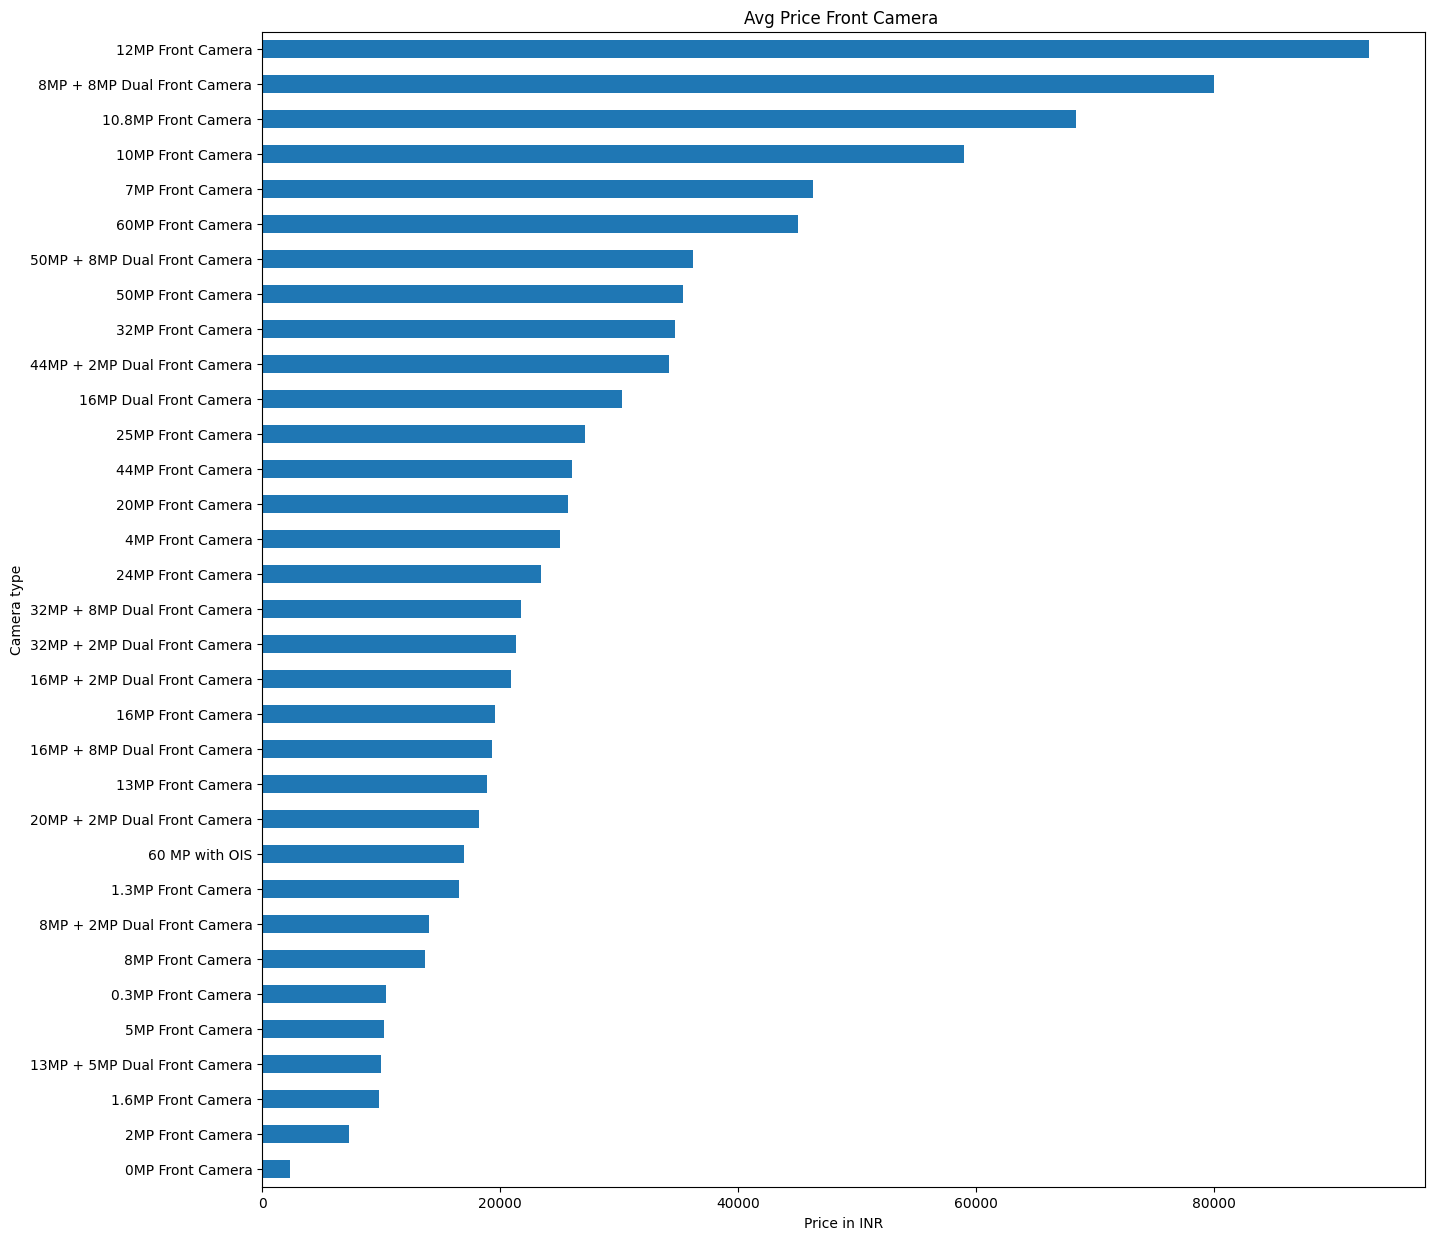

In [40]:
avg_price_camera_front.plot(kind="barh", figsize=(15,15), xlabel="Price in INR",ylabel="Camera type", title="Avg Price Front Camera ")

In [41]:
#check to see relations of features for sample Brand(Samsung)
df_samsung=dfeda.loc[dfeda['Brand']=="SAMSUNG"]

In [42]:
avg_price_camera_front_ss=price_relation(df_samsung,'Front Camera',False)

<Axes: title={'center': 'Avg Price Front Camera for Samsung'}, xlabel='Price in INR', ylabel='Camera type'>

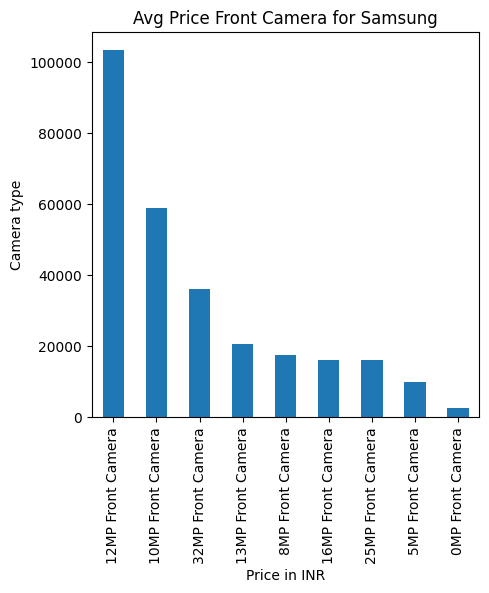

In [43]:
avg_price_camera_front_ss.plot(kind="bar", figsize=(5,5), xlabel="Price in INR",ylabel="Camera type", title="Avg Price Front Camera for Samsung")

In [44]:
avg_price_camera_back=price_relation(dfeda,'Back/Rare Camera',False)

<Axes: title={'center': 'Avg Price Back Camera '}, xlabel='Price in INR', ylabel='Camera type'>

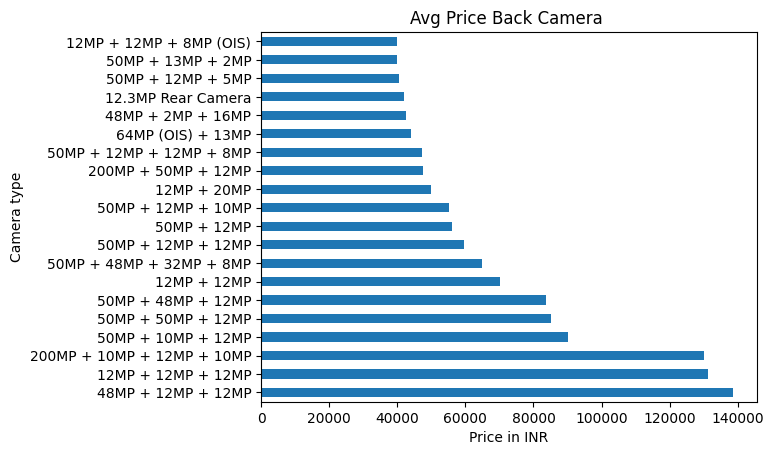

In [45]:
avg_price_camera_back.iloc[0:20].plot(kind="barh", xlabel="Price in INR",ylabel="Camera type", title="Avg Price Back Camera ")

In [46]:
avg_price_camera_back_ss=price_relation(df_samsung,'Front Camera',False)

<Axes: title={'center': 'Avg Price Front Camera '}, xlabel='Price in INR', ylabel='Camera type'>

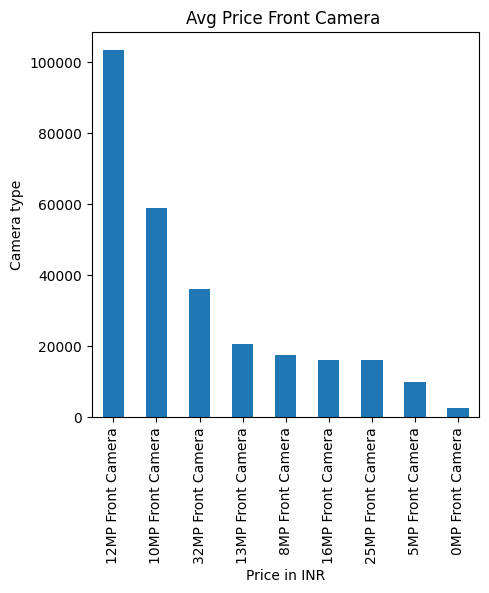

In [47]:
avg_price_camera_back_ss.plot(kind="bar", figsize=(5,5), xlabel="Price in INR",ylabel="Camera type", title="Avg Price Front Camera ")

In [48]:
"""
There does not seem to be a strong correlation between camera and price for Samsung
"""

'\nThere does not seem to be a strong correlation between camera and price for Samsung\n'

In [49]:
avg_price_ram=price_relation(dfeda,'RAM',False)

<Axes: title={'center': 'Avg Price RAM '}, xlabel='RAM type', ylabel='Price in INR'>

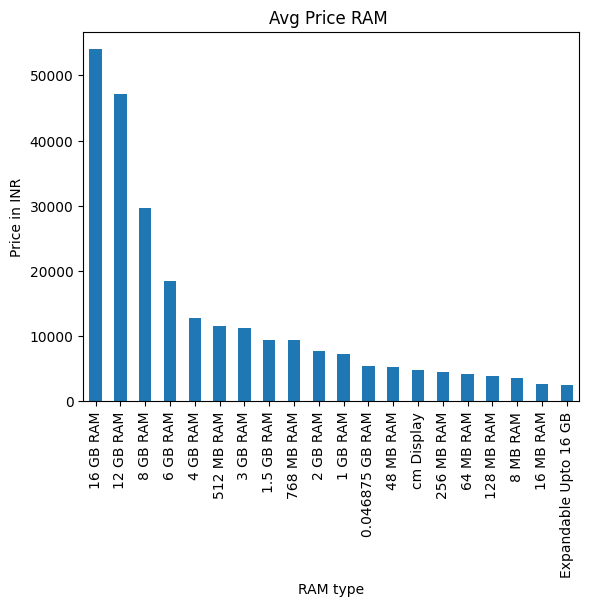

In [50]:
avg_price_ram.iloc[0:20].plot(kind="bar", ylabel="Price in INR",xlabel="RAM type", title="Avg Price RAM ")

In [51]:
"""
RAM size generally trends upwards with price, although there are exceptions.
"""

'\nRAM size generally trends upwards with price, although there are exceptions.\n'

In [52]:
avg_price_storage=price_relation(dfeda,'ROM/Storage',False)

<Axes: title={'center': 'Avg Price Storage '}, xlabel='Storage type', ylabel='Price in INR'>

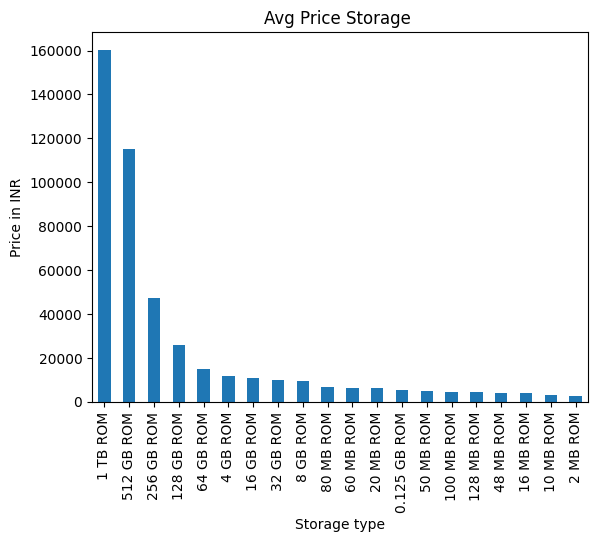

In [53]:
avg_price_storage.iloc[0:20].plot(kind="bar", xlabel="Storage type",ylabel="Price in INR", title="Avg Price Storage ")

In [54]:
"""
Storage seems to strongly affect price
"""

'\nStorage seems to strongly affect price\n'

In [55]:
avg_price_battery=price_relation(dfeda,'Battery',False)

<Axes: title={'center': 'Avg Price Battery '}, xlabel='Battery type', ylabel='Price in INR'>

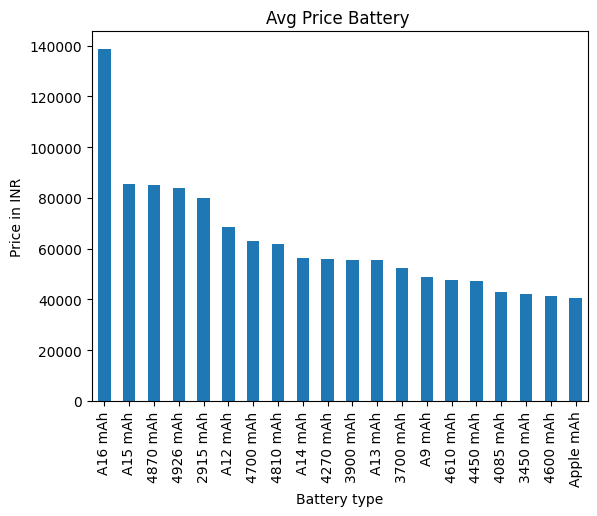

In [56]:
avg_price_battery.iloc[0:20].plot(kind="bar", ylabel="Price in INR",xlabel="Battery type", title="Avg Price Battery ")

In [57]:
"""
Prices seem to generally trend upwards depending on battery life but clearly there are other factors affecting the price.
"""

'\nPrices seem to generally trend upwards depending on battery life but clearly there are other factors affecting the price.\n'

In [58]:
avg_price_processor=price_relation(dfeda,'Processor',False)

<Axes: title={'center': 'Avg Price Processor '}, xlabel='Price in INR', ylabel='Processor type'>

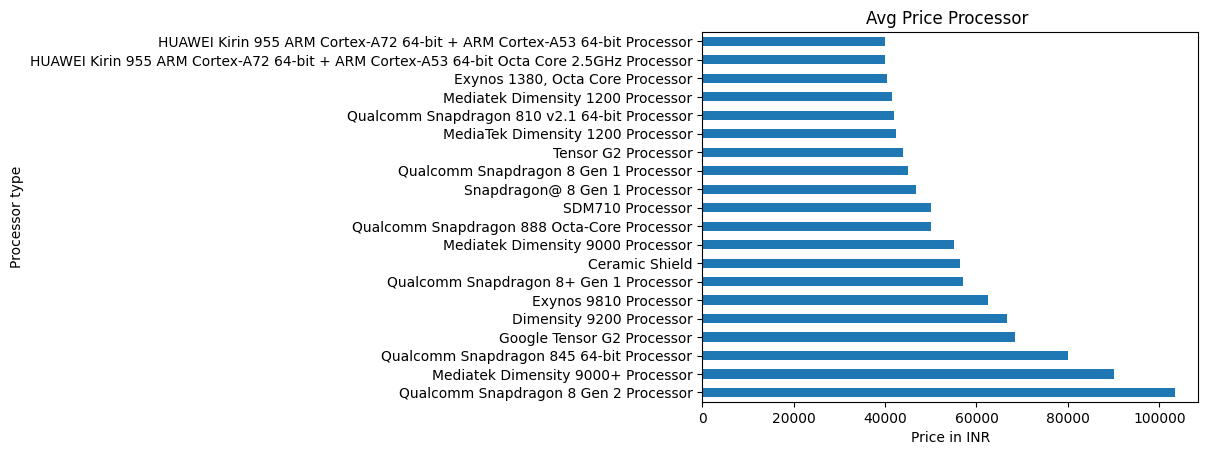

In [59]:
avg_price_processor.iloc[0:20].plot(kind="barh", xlabel="Price in INR",ylabel="Processor type", title="Avg Price Processor ")

In [60]:
"""
After comparing specs of lower price processors to the highest price (Qualcomm Snapdragon 8 Gen 2), 
it does appear that the latter has mostly higher specs
"""

'\nAfter comparing specs of lower price processors to the highest price (Qualcomm Snapdragon 8 Gen 2), \nit does appear that the latter has mostly higher specs\n'

<Axes: title={'center': 'Price and Rating'}, xlabel='Price in INR', ylabel='Rating'>

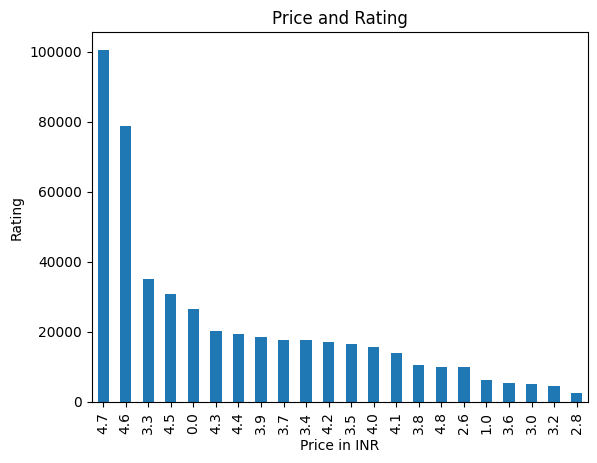

In [61]:
avg_price_rating=price_relation(dfeda,'Rating ?/5',False)
avg_price_rating.plot(kind="bar", xlabel="Price in INR",ylabel="Rating", title="Price and Rating")

In [62]:
"""
Overall, some of the features such as processor, ram, and storage seem to affect the pricing of the phone.
Lets train a model and look at it's SHAP values to see how much these features affect the prices.
"""

"\nOverall, some of the features such as processor, ram, and storage seem to affect the pricing of the phone.\nLets train a model and look at it's SHAP values to see how much these features affect the prices.\n"

In [63]:
def prepare_training_sets(df):
    X, y = df.drop('Price in INR', axis=1), df[['Price in INR']].values.reshape(-1,)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    return X, y, X_train, X_test, y_train, y_test

In [64]:
#Drop rating feature
df1=df1.drop(columns=["Rating ?/5"])

In [65]:
df2=df1.copy()

In [66]:
cats = df2.select_dtypes(include=['object']).columns.tolist()
for col in cats:
    df2[col]= df2[col].astype('category')

In [67]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1767 entries, 0 to 1766
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   RAM               1767 non-null   category
 1   ROM/Storage       1767 non-null   category
 2   Back/Rare Camera  1767 non-null   category
 3   Front Camera      1767 non-null   category
 4   Battery           1767 non-null   category
 5   Processor         1767 non-null   category
 6   Price in INR      1767 non-null   int64   
 7   Brand             1767 non-null   category
dtypes: category(7), int64(1)
memory usage: 54.4 KB


In [68]:
X_df2, y_df2, X_train_df2, X_test_df2, y_train_df2, y_test_df2 = prepare_training_sets(df2)

In [71]:
dtrain = xgb.DMatrix(X_train_df2, y_train_df2, enable_categorical=True)
dtest = xgb.DMatrix(X_test_df2, y_test_df2, enable_categorical=True)

In [72]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
n = 100
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10
)

[0]	train-rmse:24372.29583	validation-rmse:25328.11175
[10]	train-rmse:2779.23393	validation-rmse:7078.18036
[20]	train-rmse:2293.45175	validation-rmse:6734.45118
[30]	train-rmse:2173.70836	validation-rmse:6691.66512
[40]	train-rmse:2104.51585	validation-rmse:6673.68656
[50]	train-rmse:2084.14493	validation-rmse:6672.25005
[60]	train-rmse:2070.88004	validation-rmse:6665.71040
[70]	train-rmse:2067.66204	validation-rmse:6669.75071
[80]	train-rmse:2065.61847	validation-rmse:6670.01587
[90]	train-rmse:2064.91440	validation-rmse:6670.96803
[99]	train-rmse:2064.54211	validation-rmse:6674.07356


In [74]:
preds = model.predict(dtest)
rmse = mean_squared_error(y_test_df2, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 6674.074


In [75]:
y_pred=model.predict(dtrain)

Text(0.5, 0, 'actual')

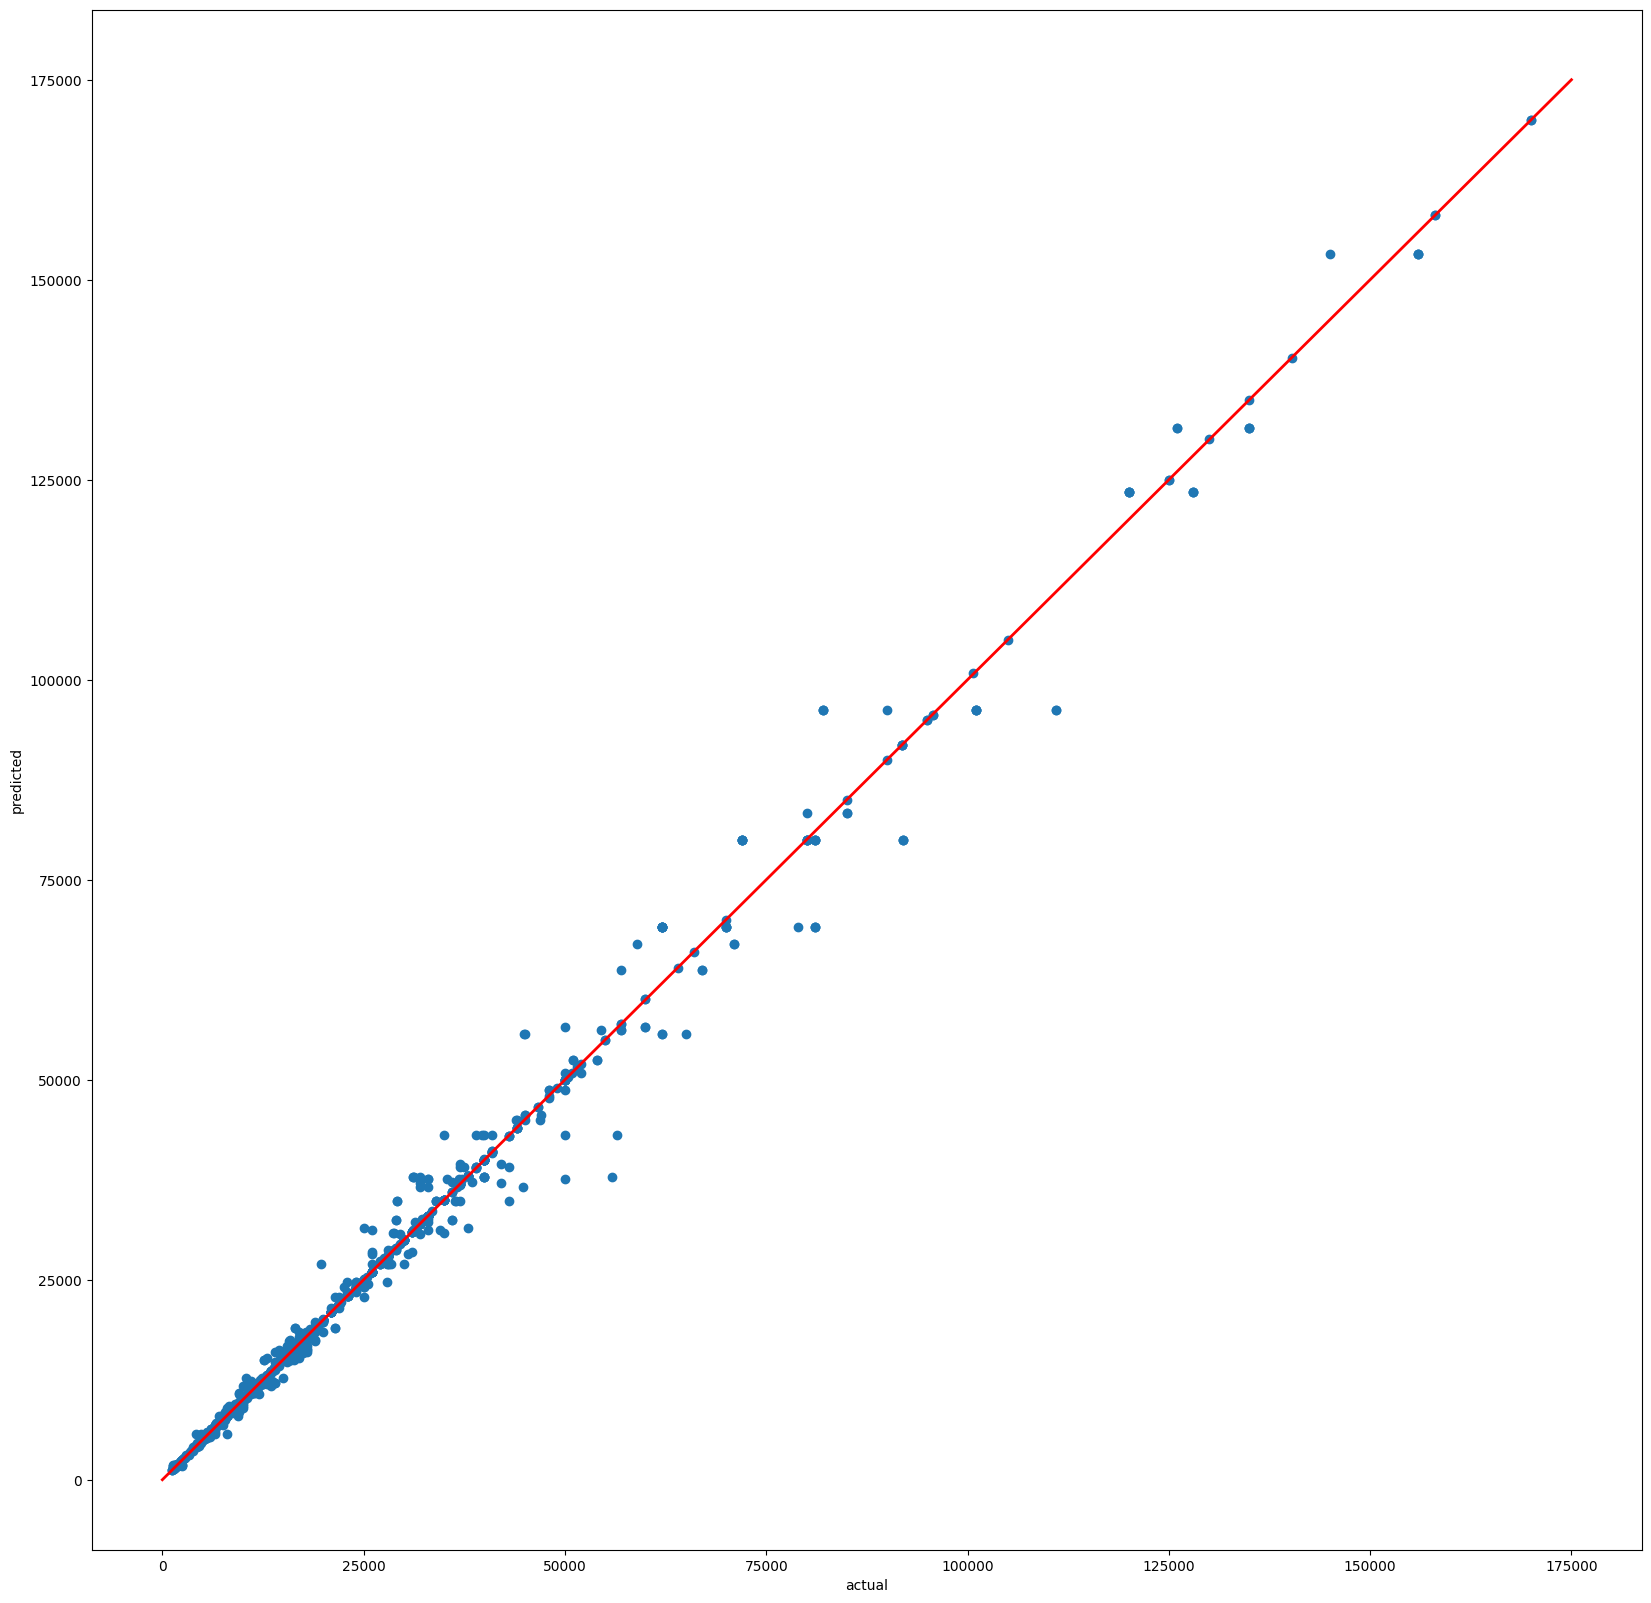

In [76]:
#plot prediction line and actual values
plt.figure(figsize=(20,20))
plt.scatter(y_train_df2, y_pred)
plt.plot([0,175000],[0,175000],color='r', linestyle='-', linewidth=2)
plt.ylabel('predicted')
plt.xlabel('actual')

In [78]:
idx = [i for i,_ in enumerate(y_train_df2)]

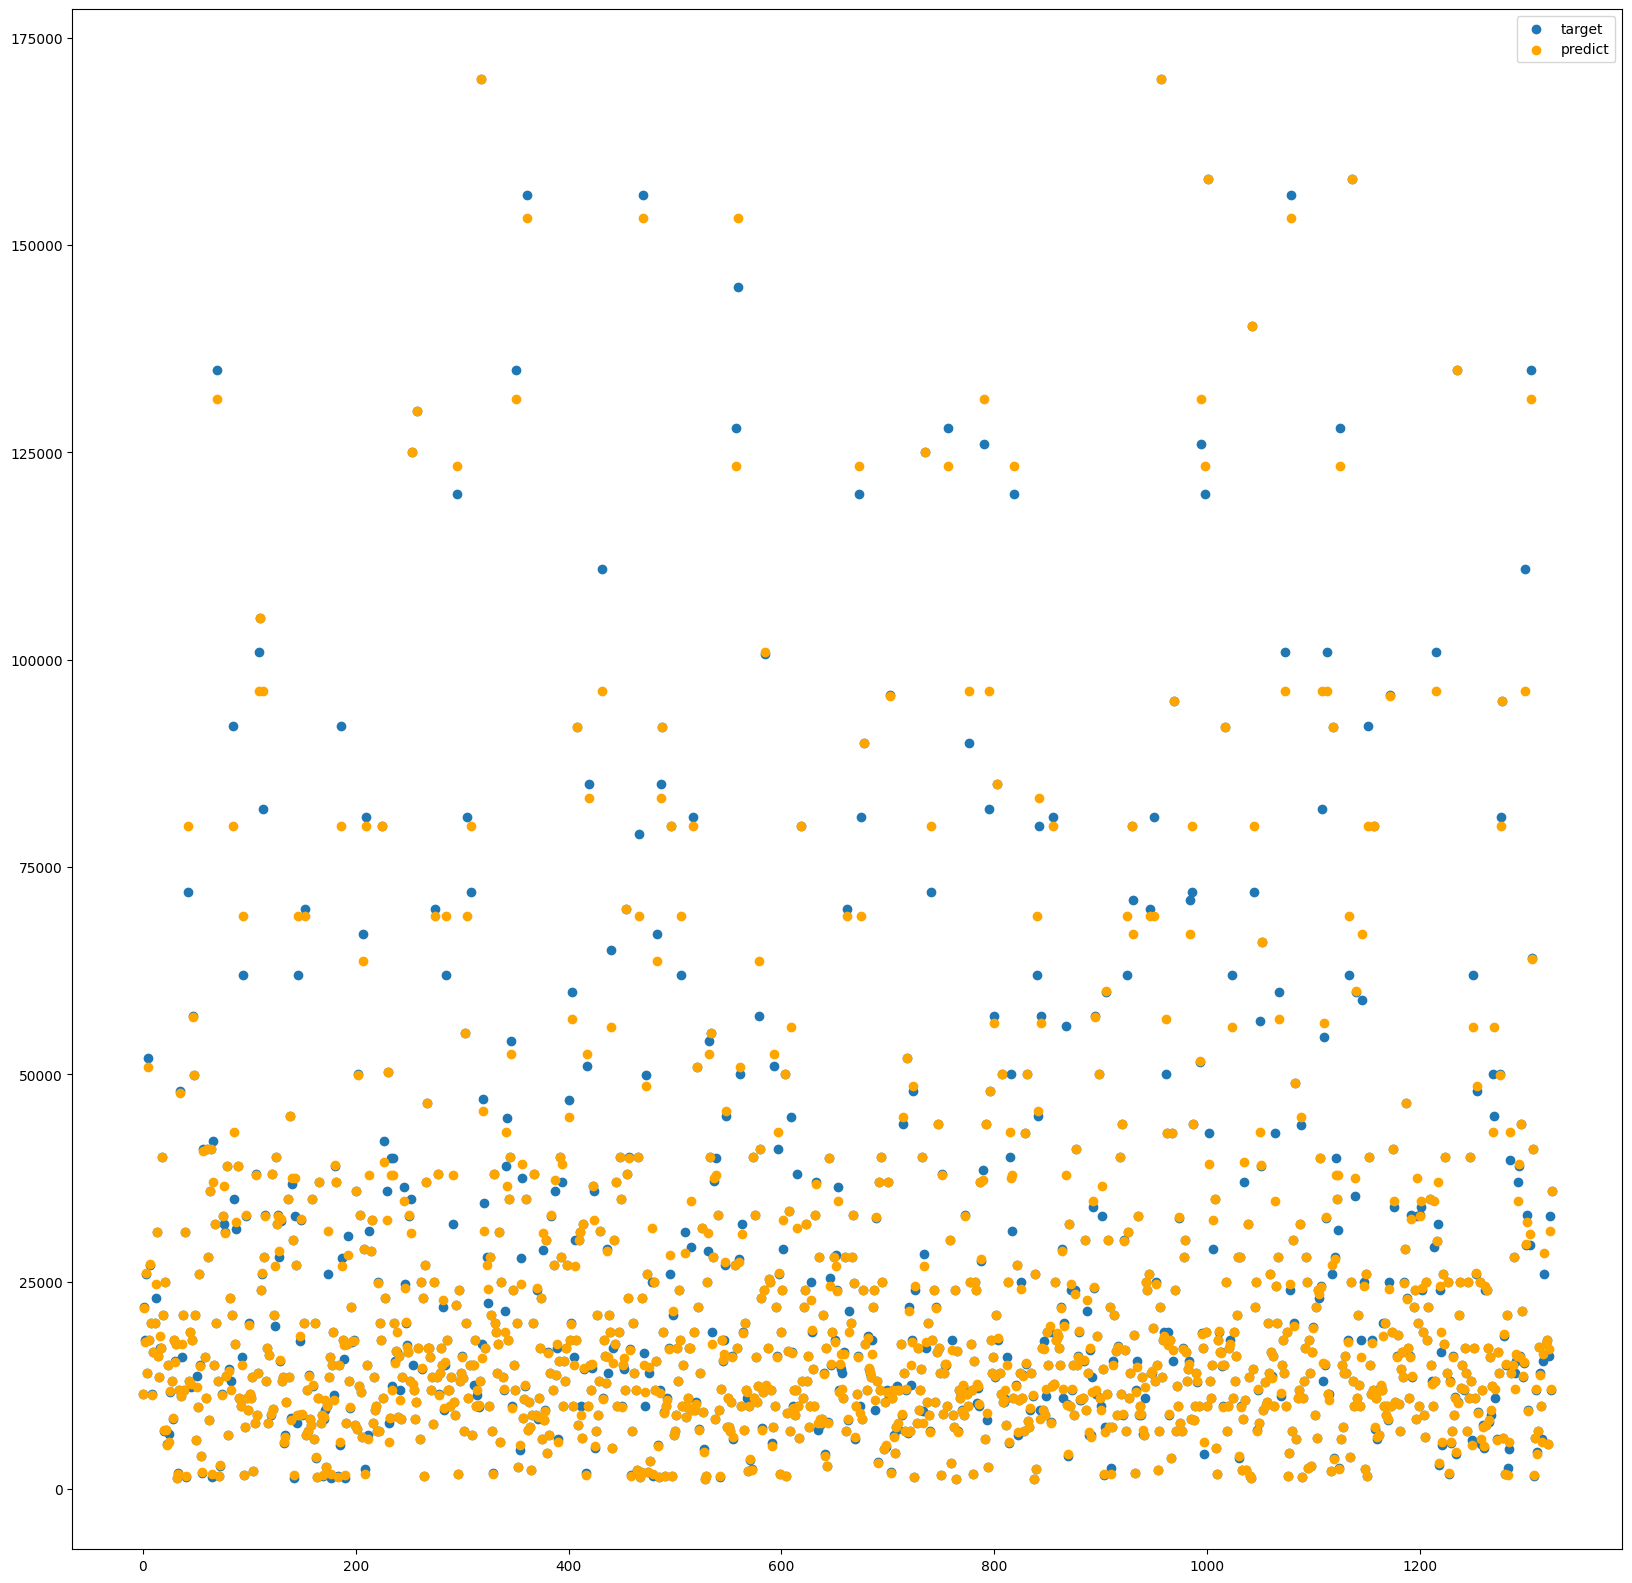

In [79]:
#plot prediction and actual values in scatter plot
plt.figure(figsize=(20,20))
plt.scatter(idx, y_train_df2, label='target')
plt.scatter(idx, y_pred, color='orange', label='predict')
plt.legend()
plt.show()

In [ ]:
"""
Overall, it seems the model was able to fit the data to a reasonable degree. 
However, in order to see it's SHAP values, the features will need to be encoded into integer datatype
"""

In [80]:
#label encoder section
df2=df1.copy()

In [81]:
cats = df2.select_dtypes(include=['object']).columns.tolist()
for col in cats:
    df2[col]= label_encoder.fit_transform(df2[col])

In [82]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1767 entries, 0 to 1766
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   RAM               1767 non-null   int32
 1   ROM/Storage       1767 non-null   int32
 2   Back/Rare Camera  1767 non-null   int32
 3   Front Camera      1767 non-null   int32
 4   Battery           1767 non-null   int32
 5   Processor         1767 non-null   int32
 6   Price in INR      1767 non-null   int64
 7   Brand             1767 non-null   int32
dtypes: int32(7), int64(1)
memory usage: 62.2 KB


In [83]:
X_df2, y_df2, X_train_df2, X_test_df2, y_train_df2, y_test_df2 = prepare_training_sets(df2)

In [84]:
model2 = xgb.XGBRegressor(objective="reg:squarederror",tree_method="gpu_hist")

In [85]:
model2.fit(X_train_df2, y_train_df2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [86]:
preds = model2.predict(X_test_df2)
rmse = mean_squared_error(y_test_df2, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")
#It seems converting the features to integer labels seemed to help with model accuracy as well

RMSE of the base model: 5491.708


In [ ]:
"""
Mean squared error seems to be lower than first model after encoding features to int labels

"""

In [87]:
y_pred2=model2.predict(X_train_df2)

Text(0.5, 0, 'actual')

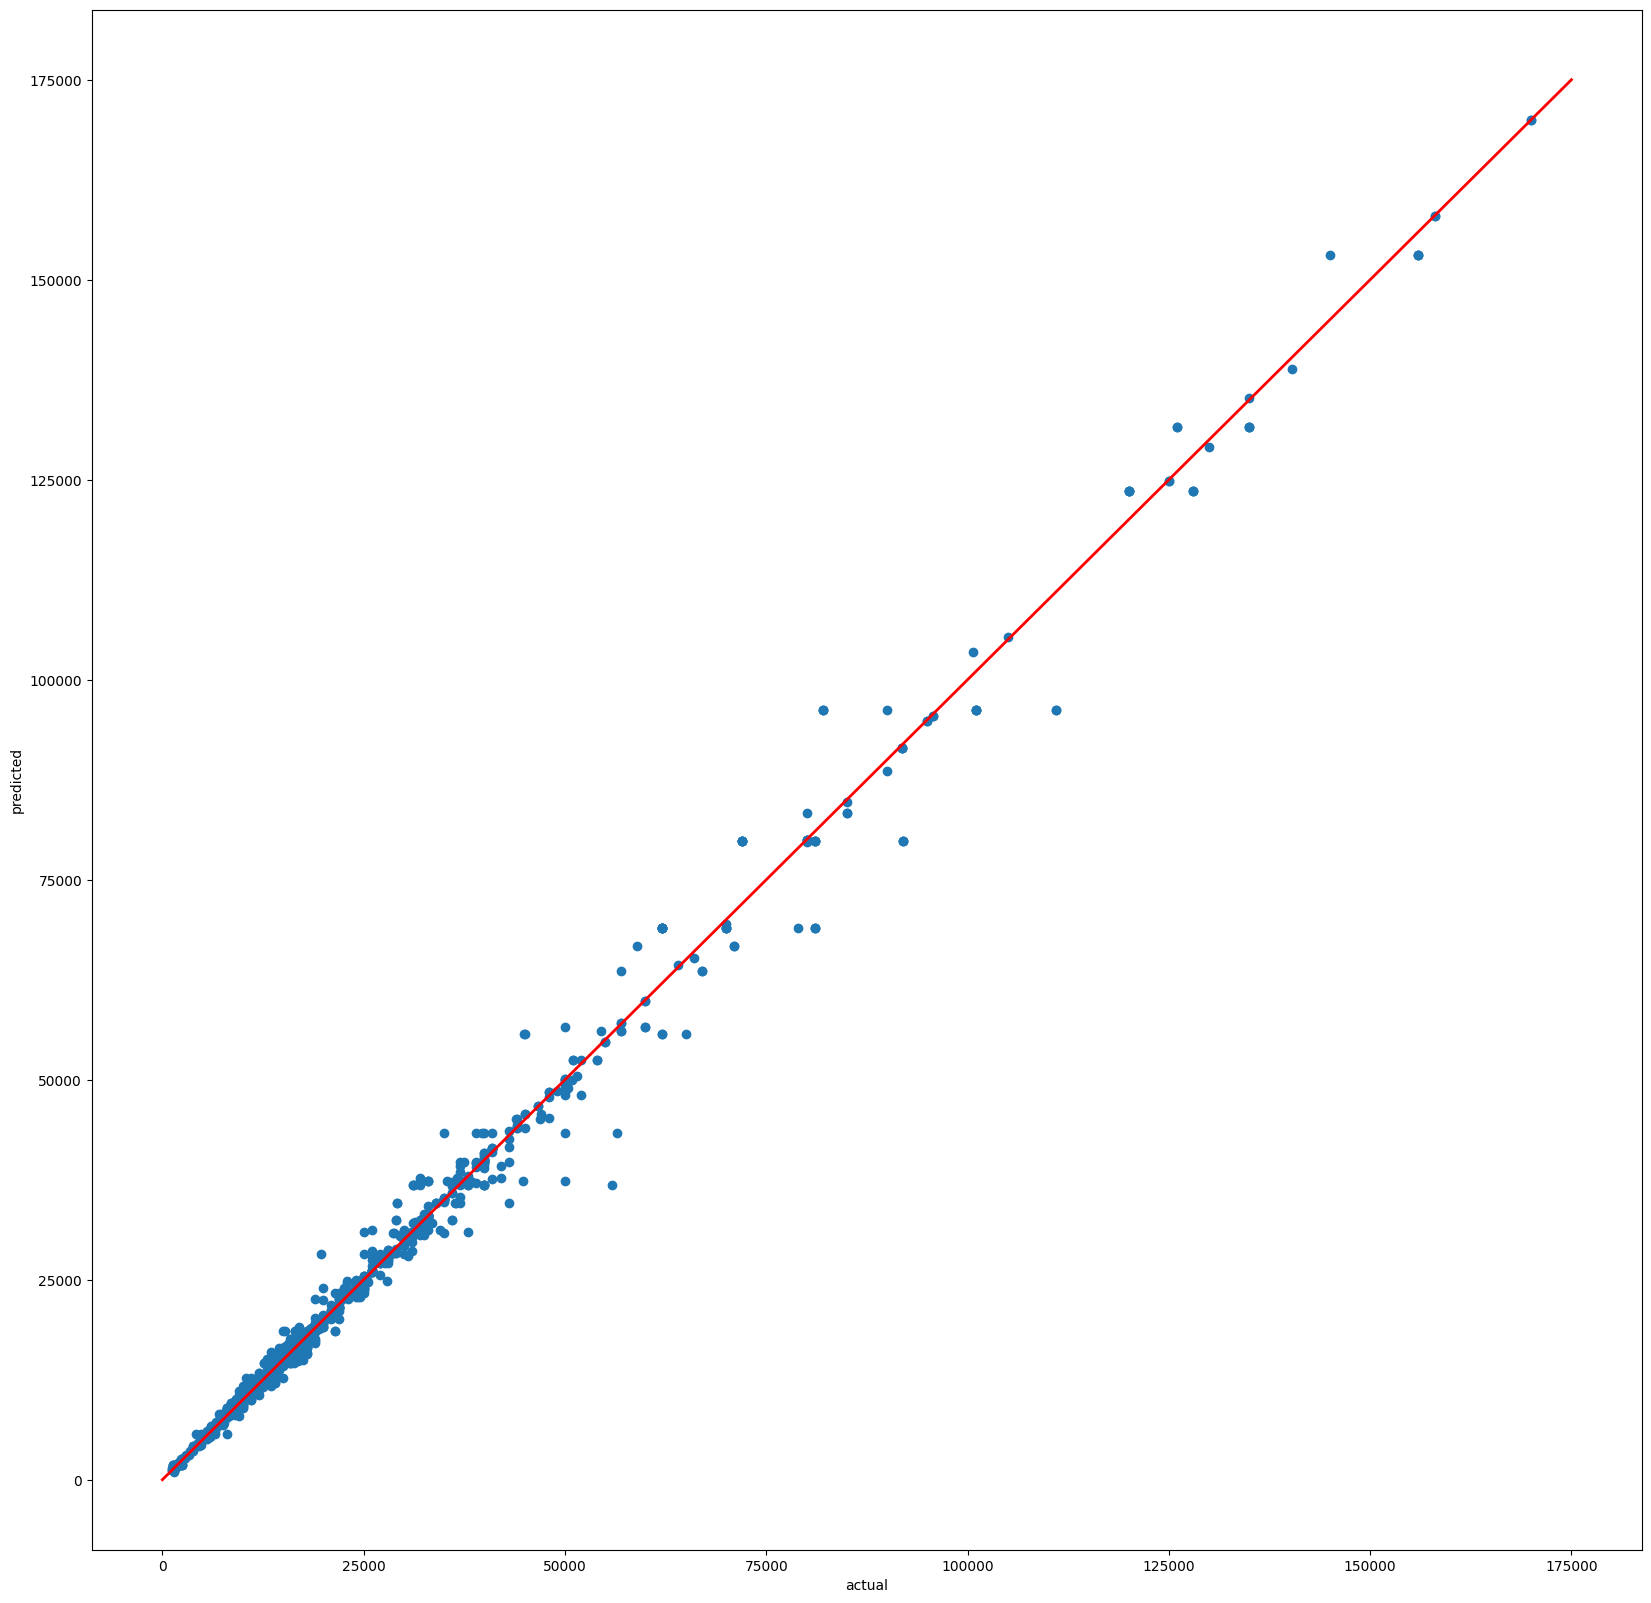

In [88]:
plt.figure(figsize=(20,20))
plt.scatter(y_train_df2, y_pred2)
plt.plot([0,175000],[0,175000],color='r', linestyle='-', linewidth=2)
plt.ylabel('predicted')
plt.xlabel('actual')

In [89]:
explainer = shap.Explainer(model2)

In [90]:
shap_values=explainer(X_train_df2)

In [91]:
np.shape(shap_values.values)

(1325, 7)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


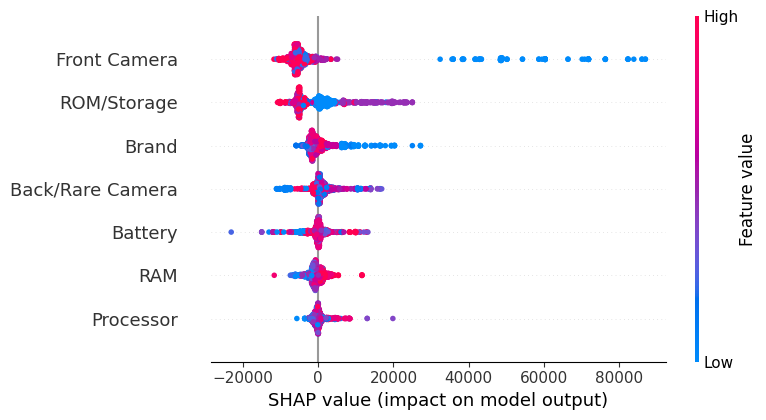

In [92]:
shap.summary_plot(shap_values, X_train_df2)

Viewing choice 824


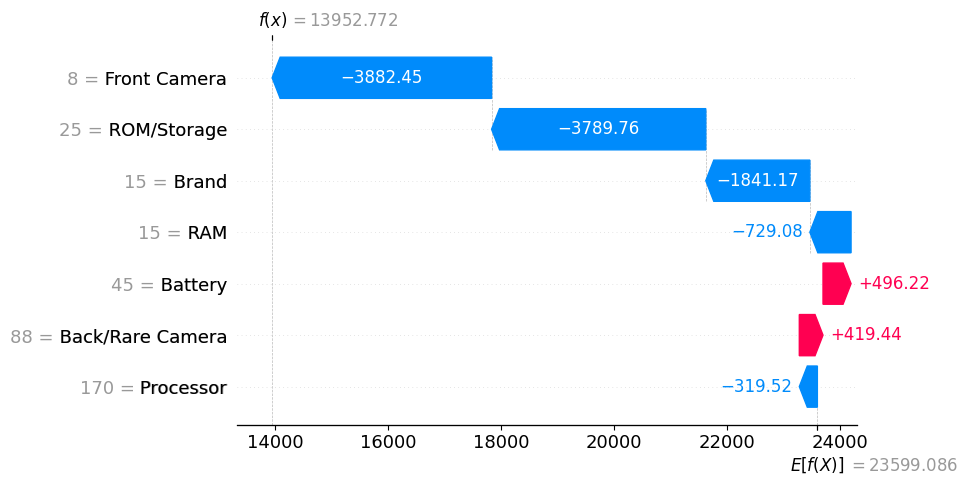

In [93]:
random=np.random.choice(1377)
print(f"Viewing choice {random}")
shap.plots.waterfall(shap_values[random])

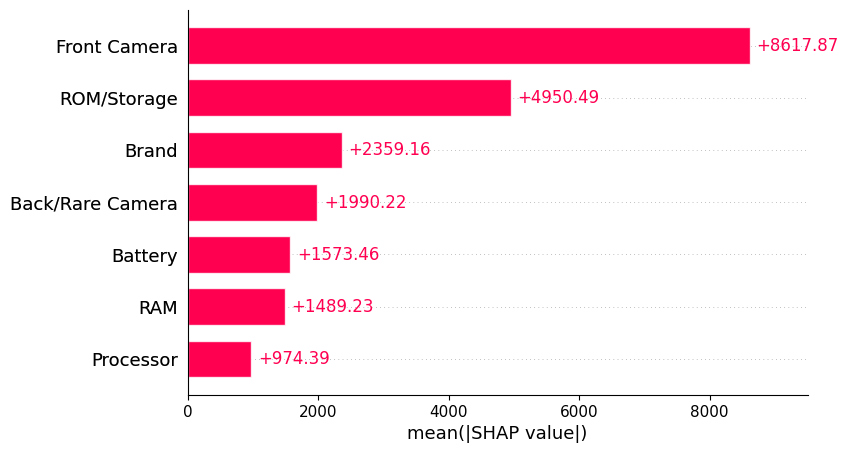

In [94]:
shap.plots.bar(shap_values)

In [95]:
random=np.random.choice(1377)
print(f"Viewing choice {random}")
shap.plots.force(shap_values[random])

Viewing choice 1091


In [ ]:
"""
Some of the features such as RAM have too many unique labels. 
Use rare label encoder to only consider RAMs that appear more than 9 times.
"""

In [96]:
#retrieve dataframe for only one brand if brand name is provided, otherwise all brands
def prepare_brand_data(df,brand_name="All"):
    df_brand=df.copy()
    if brand_name!="All":
        df_brand=df.loc[dfcat['Brand']==brand_name]
        df_brand=df_brand.drop(columns=['Brand'])
    
    cats = df_brand.select_dtypes(include=['object']).columns.tolist()
    for col in cats:
        df_brand[col]= rare_encoder.fit_transform(df_brand[[col]])
    for col in cats:
        df_brand[col]= label_encoder.fit_transform(df_brand[col])
    return df_brand

In [97]:
def prepare_training_sets_brand(df):
    X, y = df.drop('Price in INR', axis=1), df[['Price in INR']].values.reshape(-1,)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    cat_features=list(range(0,X.shape[1]))
    train_pool=Pool(X_train, y_train, cat_features=cat_features)
    test_pool=Pool(X_test, y_test, cat_features=cat_features)
    
    return X, y, X_train, X_test, y_train, y_test, cat_features, train_pool, test_pool

In [98]:
#rare label encoder section
df3=df1.copy()

In [99]:
df3=prepare_brand_data(df3)

In [100]:
X_df3, y_df3, X_train_df3, X_test_df3, y_train_df3, y_test_df3=prepare_training_sets(df3)

In [101]:
model3 = xgb.XGBRegressor(objective="reg:squarederror",tree_method="gpu_hist")

In [102]:
model3.fit(X_train_df3,y_train_df3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [103]:
preds = model3.predict(X_test_df3)
rmse = mean_squared_error(y_test_df3, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 5402.681


In [104]:
explainer_m3 = shap.Explainer(model3)

In [105]:
shap_values=explainer_m3(X_test_df3)

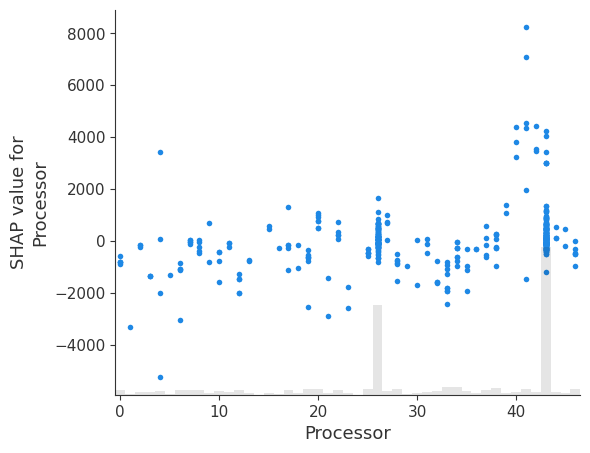

In [106]:
shap.plots.scatter(shap_values[:,"Processor"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


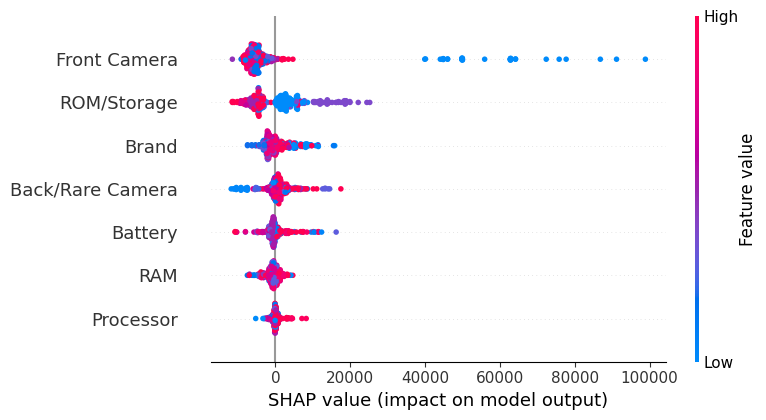

In [107]:
shap.summary_plot(shap_values, X_test_df3)

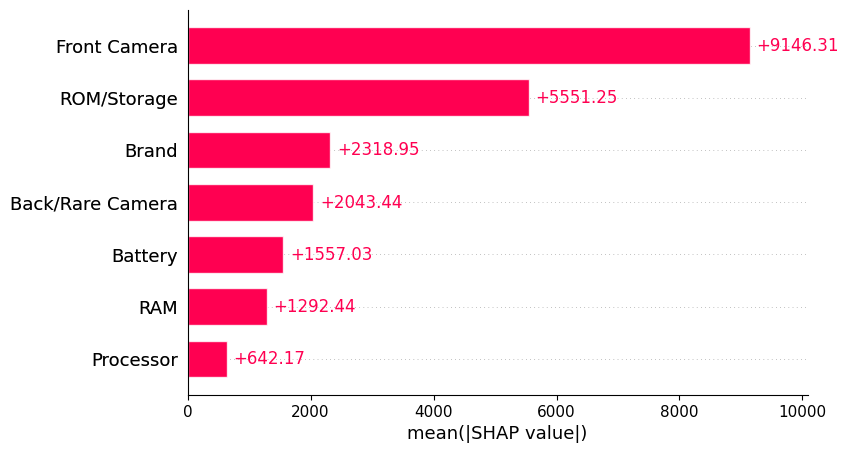

In [108]:
shap.plots.bar(shap_values)

In [110]:
random=np.random.choice(len(X_test_df3))
print(f"Viewing choice {random}")
shap.plots.force(shap_values[random])

Viewing choice 309


In [ ]:
"""
Bar and waterfall plots seemed to be the most useful SHAP plots.

Previous models were using xgboost. 
Now to experiment with Catboost
"""

In [111]:
dfcat=df1.copy()

In [112]:
dfcat1=prepare_brand_data(dfcat)

X_cat, y_cat, X_train_cat, X_test_cat, y_train_cat, y_test_cat, cat_features_cat, train_pool_cat, test_pool_cat = prepare_training_sets_brand(dfcat1)

In [113]:
modelcat=CatBoostRegressor(iterations=1000, learning_rate=0.01, loss_function='RMSE', task_type="GPU", devices='0:1',verbose=10)

In [114]:
modelcat.fit(train_pool_cat, eval_set=(X_test_cat, y_test_cat), verbose=100)

0:	learn: 24055.6443783	test: 24529.2315176	best: 24529.2315176 (0)	total: 27.3ms	remaining: 27.3s
100:	learn: 13251.5961357	test: 13795.6054961	best: 13795.6054961 (100)	total: 2.57s	remaining: 22.9s
200:	learn: 9285.9443915	test: 10027.1747761	best: 10027.1747761 (200)	total: 5.15s	remaining: 20.5s
300:	learn: 7831.0811094	test: 8690.2219936	best: 8690.2219936 (300)	total: 7.69s	remaining: 17.9s
400:	learn: 7214.8742292	test: 8108.3352097	best: 8108.3352097 (400)	total: 10.3s	remaining: 15.3s
500:	learn: 6854.4037771	test: 7788.2661387	best: 7788.2661387 (500)	total: 12.9s	remaining: 12.8s
600:	learn: 6603.9944514	test: 7600.5918893	best: 7600.5918893 (600)	total: 15.4s	remaining: 10.3s
700:	learn: 6443.9909406	test: 7473.4241863	best: 7473.4241863 (700)	total: 18.1s	remaining: 7.71s
800:	learn: 6272.9262928	test: 7336.6614820	best: 7336.6614820 (800)	total: 20.8s	remaining: 5.17s
900:	learn: 6104.8415019	test: 7216.7363853	best: 7216.7270756 (898)	total: 23.4s	remaining: 2.57s
999:	

In [115]:
y_cv_cat = modelcat.predict(test_pool_cat)
error = mean_squared_error(y_test_cat, y_cv_cat, squared=False)
print(f"RMSE for cv is {round(error)}")

RMSE for cv is 7110


In [116]:
explainer_cat = shap.Explainer(modelcat)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


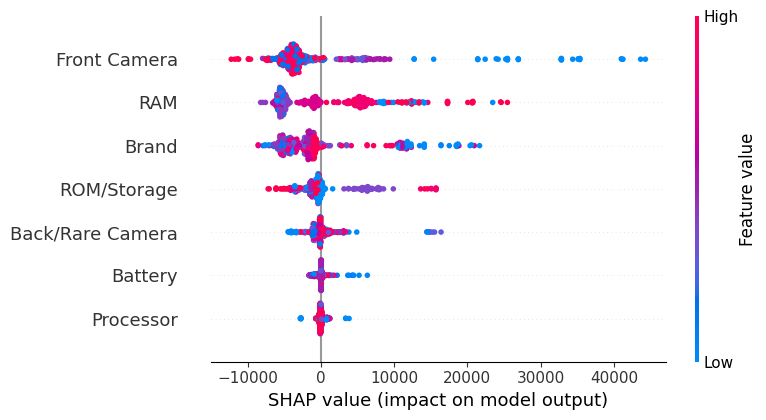

In [117]:
shap_values=explainer_cat(X_test_cat)
#shap_values = explainer_cat.shap_values(X_train)
shap.summary_plot(shap_values,X_test_cat)

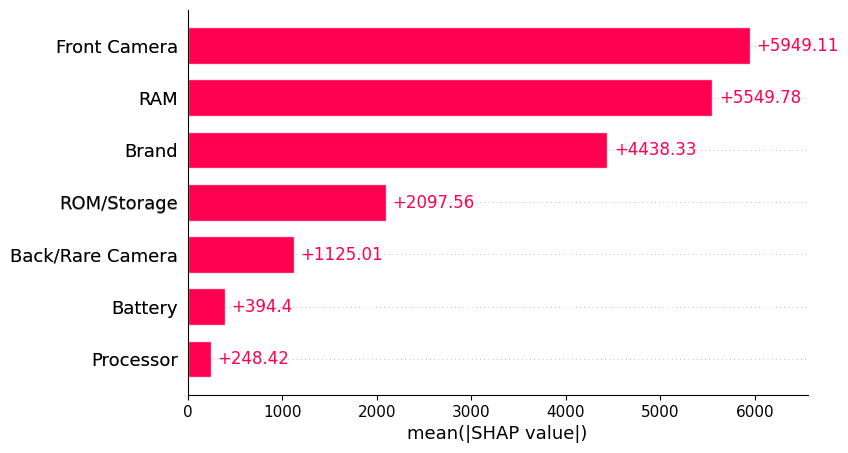

In [118]:
shap.plots.bar(shap_values)

In [119]:
"""
Catboost seems to weigh the features differently than the models used by xgboost.
In this case, it seemed to give a more balanced weight to the top features.
"""

'\nCatboost seems to weigh the features differently than the models used by xgboost.\nIn this case, it seemed to give a more balanced weight to the top features.\n'

In [120]:
random=np.random.choice(len(X_test_cat))
print(f"Viewing choice {random}")
shap.plots.force(shap_values[random])

Viewing choice 346


In [ ]:
"""
The brand feature seems to have a relatively high impact on the overall price. 
Let's look at the top 3 brands to see how they value the other features.
"""

In [121]:
dfcat_samsung=prepare_brand_data(dfcat,"SAMSUNG")

X_ss, y_ss, X_train_ss, X_test_ss, y_train_ss, y_test_ss, cat_features_ss, train_pool_ss, test_pool_ss = prepare_training_sets_brand(dfcat_samsung)

In [122]:
modelcat_ss=CatBoostRegressor(iterations=1000, learning_rate=0.01, loss_function='RMSE', task_type="GPU", devices='0:1',verbose=10)

In [123]:
modelcat_ss.fit(train_pool_ss, eval_set=(X_test_ss, y_test_ss), verbose=100)

0:	learn: 24006.8223599	test: 22002.5749766	best: 22002.5749766 (0)	total: 21.6ms	remaining: 21.6s
100:	learn: 13724.9303388	test: 14715.4276957	best: 14715.4276957 (100)	total: 1.93s	remaining: 17.2s
200:	learn: 9111.5163521	test: 11678.4747863	best: 11678.4747863 (200)	total: 3.85s	remaining: 15.3s
300:	learn: 6861.0136880	test: 10236.0029699	best: 10236.0029699 (300)	total: 5.84s	remaining: 13.6s
400:	learn: 5721.2444167	test: 9510.2497969	best: 9510.2497969 (400)	total: 7.9s	remaining: 11.8s
500:	learn: 5108.6707058	test: 9147.6619089	best: 9147.6619089 (500)	total: 10.1s	remaining: 10.1s
600:	learn: 4687.0508315	test: 8899.6203664	best: 8899.5762596 (599)	total: 12.3s	remaining: 8.17s
700:	learn: 4423.1153105	test: 8774.5075607	best: 8774.5075607 (700)	total: 14.4s	remaining: 6.15s
800:	learn: 4188.6436305	test: 8717.2658711	best: 8717.2658711 (800)	total: 17.2s	remaining: 4.28s
900:	learn: 3984.6592082	test: 8683.0777953	best: 8682.8296463 (898)	total: 20.1s	remaining: 2.21s
999:

In [124]:
y_cv_ss = modelcat_ss.predict(test_pool_ss)
error = mean_squared_error(y_test_ss, y_cv_ss, squared=False)
print(f"RMSE for cv is {round(error)}")

RMSE for cv is 8675


In [125]:
explainer_cat_ss = shap.Explainer(modelcat_ss)

In [127]:
shap_values_ss=explainer_cat_ss(X_test_ss)

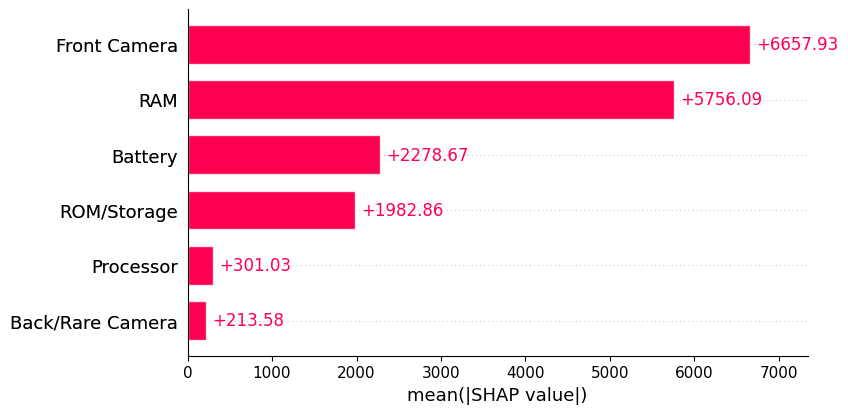

In [128]:
shap.plots.bar(shap_values_ss)

In [129]:
dfcat_realme=prepare_brand_data(dfcat,"Realme")

X_rm, y_rm, X_train_rm, X_test_rm, y_train_rm, y_test_rm, cat_features_rm, train_pool_rm, test_pool_rm = prepare_training_sets_brand(dfcat_realme)

In [130]:
modelcat_rm=CatBoostRegressor(iterations=1000, learning_rate=0.01, loss_function='RMSE', task_type="GPU", devices='0:1',verbose=10)

In [131]:
modelcat_rm.fit(train_pool_rm, eval_set=(X_test_rm, y_test_rm), verbose=100)

0:	learn: 6965.2931570	test: 6815.5936418	best: 6815.5936418 (0)	total: 20.2ms	remaining: 20.2s
100:	learn: 4424.6061737	test: 4112.7676729	best: 4112.7676729 (100)	total: 1.9s	remaining: 16.9s
200:	learn: 3455.1135665	test: 3066.4652008	best: 3066.4652008 (200)	total: 3.84s	remaining: 15.3s
300:	learn: 2943.0521218	test: 2617.0427111	best: 2617.0427111 (300)	total: 6.05s	remaining: 14.1s
400:	learn: 2587.8398071	test: 2383.5357104	best: 2383.5357104 (400)	total: 8.66s	remaining: 12.9s
500:	learn: 2310.1983099	test: 2226.3334323	best: 2226.3334323 (500)	total: 11.4s	remaining: 11.3s
600:	learn: 2095.2644873	test: 2131.1788546	best: 2131.1788546 (600)	total: 13.9s	remaining: 9.2s
700:	learn: 1936.9703774	test: 2064.6067005	best: 2064.6067005 (700)	total: 16.6s	remaining: 7.08s
800:	learn: 1833.0309844	test: 2034.5698520	best: 2034.5503273 (798)	total: 19.2s	remaining: 4.77s
900:	learn: 1756.2156898	test: 2014.9879781	best: 2014.7678227 (897)	total: 22s	remaining: 2.41s
999:	learn: 1693.

In [132]:
y_cv_rm = modelcat_rm.predict(test_pool_rm)
error = mean_squared_error(y_test_rm, y_cv_rm, squared=False)
print(f"RMSE for cv is {round(error)}")

RMSE for cv is 2007


In [133]:
explainer_cat_rm = shap.Explainer(modelcat_rm)
shap_values_rm=explainer_cat_rm(X_test_rm)

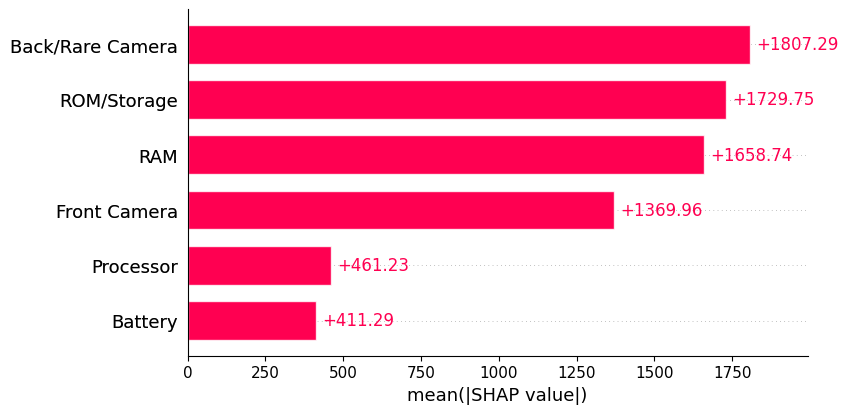

In [134]:
shap.plots.bar(shap_values_rm)

In [135]:
dfcat_vivo=prepare_brand_data(dfcat,"vivo")

X_vv, y_vv, X_train_vv, X_test_vv, y_train_vv, y_test_vv, cat_features_vv, train_pool_vv, test_pool_vv = prepare_training_sets_brand(dfcat_vivo)

In [136]:
modelcat_vv=CatBoostRegressor(iterations=1000, learning_rate=0.01, loss_function='RMSE', task_type="GPU", devices='0:1',verbose=10)

In [137]:
modelcat_vv.fit(train_pool_vv, eval_set=(X_test_vv, y_test_vv), verbose=100)

0:	learn: 12333.5289021	test: 15121.3642038	best: 15121.3642038 (0)	total: 19.2ms	remaining: 19.2s
100:	learn: 7821.3295217	test: 10607.5140856	best: 10607.5140856 (100)	total: 1.93s	remaining: 17.2s
200:	learn: 5971.5383750	test: 8657.7947805	best: 8657.7947805 (200)	total: 3.85s	remaining: 15.3s
300:	learn: 5069.7230188	test: 7601.0985441	best: 7601.0985441 (300)	total: 5.75s	remaining: 13.3s
400:	learn: 4571.8758536	test: 7013.9763769	best: 7013.9763769 (400)	total: 7.93s	remaining: 11.8s
500:	learn: 4240.2792361	test: 6639.1183845	best: 6639.1183845 (500)	total: 9.99s	remaining: 9.95s
600:	learn: 4007.0604354	test: 6418.6347937	best: 6417.5996471 (599)	total: 12.2s	remaining: 8.13s
700:	learn: 3848.4509571	test: 6296.2973246	best: 6294.2153663 (697)	total: 14.1s	remaining: 6.02s
800:	learn: 3732.4204012	test: 6221.6893081	best: 6220.8285374 (798)	total: 15.9s	remaining: 3.95s
900:	learn: 3635.8122995	test: 6177.4362619	best: 6177.4362619 (900)	total: 17.9s	remaining: 1.97s
999:	lea

In [138]:
y_cv_vv = modelcat_vv.predict(test_pool_vv)
error = mean_squared_error(y_test_vv, y_cv_vv, squared=False)
print(f"RMSE for cv is {round(error)}")

RMSE for cv is 6141


In [139]:
explainer_cat_vv = shap.Explainer(modelcat_vv)
shap_values_rm=explainer_cat_rm(X_test_vv)

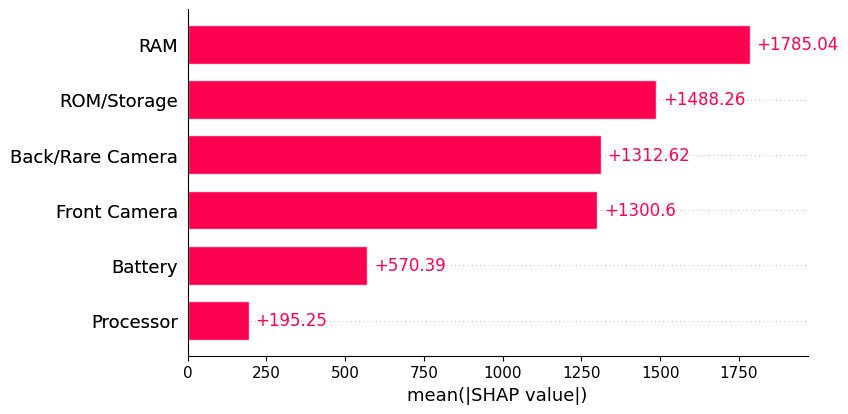

In [140]:
shap.plots.bar(shap_values_rm)

In [ ]:
"""
Looking at the top 3 selling phones in this dataset, 
it appears that each company weighs features differently when it comes to pricing.

Certain features such as RAM, Camera, and storage seem to stay around the top 3 most contributing features.
This was also seen in the SHAP for all brands. 
So it can be concluded that RAM, Camera, and Storage are the most contributing factors in a phone's price out of these avaliable features.
"""